In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Generador de imagenes del Fractal de Sierpinski

Vamos a generar una imagen del fractal de Sierpinski, para analizarlo posteriormente con el calculador de dimensiones fractales. 

La dimensión de dicho fractal es 1.58 si no mal recuerdo.

In [10]:
class Point:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Triangle:
    
    def __init__(self, point1, point2, point3):
        self.point1 = point1
        self.point2 = point2
        self.point3 = point3
        
    def getArea(self):
        A = (1/2)*((self.point2.x - self.point1.x)*(self.point3.y - self.point1.y) - (self.point3.x - self.point1.x)*(self.point2.y - self.point1.y))
        return A
    
    def isInsideTriangle(self, point):
        tolerance = 0.001
        triangle1 = Triangle(self.point1, self.point2, point)
        triangle2 = Triangle(self.point2, self.point3, point)
        triangle3 = Triangle(self.point3, self.point1, point)
        sumAreas = triangle1.getArea() + triangle2.getArea() + triangle3.getArea()
        if(np.abs(sumAreas - self.getArea())< tolerance):
            return True
        else:
            return False



class SierpinskiImageGenerator:
    
    def __init__(self):
        triangleLength = 1
        self.triangles = []
        point1 = Point(0,0)
        point2 = Point(triangleLength, 0)
        point3 = Point(triangleLength/2, np.sqrt(triangleLength**2 - (triangleLength/2)**2))
        self.initTriangle = Triangle(point1, point2, point3)
        self.triangles.append(self.initTriangle)
        self.triangleLength = triangleLength
        self.triangleHeight = np.sqrt(triangleLength**2 - (triangleLength/2)**2)
    
    def resetFractal(self):
        self.triangles = []
        self.triangles.append(self.initTriangle)
        
    def evolve(self, nSteps):
        
        for i in range(0,nSteps):
            newTriangles = []
            for j in range(0,len(self.triangles)):
                triangle = self.triangles[j]
                #Creamos tres triangulos nuevos
                midPoint1 = Point((triangle.point1.x + triangle.point2.x)/2, (triangle.point1.y + triangle.point2.y)/2)
                midPoint2 = Point((triangle.point2.x + triangle.point3.x)/2,(triangle.point2.y + triangle.point3.y)/2)
                midPoint3 = Point((triangle.point3.x + triangle.point1.x)/2, (triangle.point3.y + triangle.point1.y)/2)
                
                triangle1 = Triangle(triangle.point1, midPoint1, midPoint3)
                triangle2 = Triangle(midPoint1, triangle.point2, midPoint2)
                triangle3 = Triangle(midPoint3,midPoint2, triangle.point3)
                
                newTriangles.append(triangle1)
                newTriangles.append(triangle2)
                newTriangles.append(triangle3)
            
            self.triangles = newTriangles
    
    def getImage(self, imageWidth, imageHeight):
        colorSierpinski = [107/255, 164/255, 255/255]
        image = np.zeros((imageHeight, imageWidth, 3))
        deltaX = imageWidth/self.triangleLength
        deltaY = imageHeight/self.triangleHeight
        
        
        for i in range(0,len(self.triangles)):
            triangle = self.triangles[i]
            initX = np.min([triangle.point1.x, triangle.point2.x, triangle.point3.x])
            endX = np.max([triangle.point1.x, triangle.point2.x, triangle.point3.x])
            initY = np.min([triangle.point1.y, triangle.point2.y, triangle.point3.y])
            endY = np.max([triangle.point1.y, triangle.point2.y, triangle.point3.y])
            
            initXIndex = int(np.floor(initX*deltaX))
            endXIndex = int(np.floor(endX*deltaX))
            initYIndex = int(np.floor(initY*deltaY))
            endYIndex = int(np.floor(endY*deltaY))
            
            if(endXIndex == imageWidth):
                endXIndex = imageWidth -1
            if(endYIndex == imageHeight):
                endYIndex = imageHeight - 1
            
            
            for n in range(initXIndex, endXIndex):
                for m in range(initYIndex, endYIndex):
                    xPos = n/deltaX
                    yPos = m/deltaY
                    point = Point(xPos, yPos)
                    if(triangle.isInsideTriangle(point)):
                        image[m,n,:] = colorSierpinski
            
        return np.flip(image,0)
        
            
        
        
        
        

In [11]:

sierpinskiImageGenerator = SierpinskiImageGenerator()

In [12]:
sierpinskiImageGenerator.resetFractal()
sierpinskiImageGenerator.evolve(9)

In [13]:
imageWidth = 1000
imageHeight = 1000

imageSierpinski = sierpinskiImageGenerator.getImage(imageWidth, imageHeight)

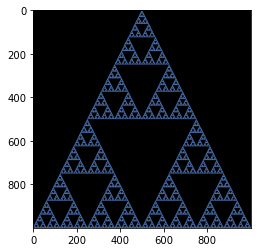

In [ ]:
plt.figure()
plt.imshow(imageSierpinski)

## Dimensión fractal

In [22]:
class FractalDimensionCalculator:
    
    def __init__(self, image):
        
        self.image = image
        if(image.ndim == 3):
            self.colorImage = True
        else:
            self.colorImage = False
        
    
    def computeBoxFractalDimension(self, boxLength):
        imageWidth = np.size(self.image, 0)
        imageHeight = np.size(self.image, 1)
        
        nStepsWidth =imageWidth//boxLength
        nStepsHeight = imageHeight//boxLength
        
        scale = imageWidth/boxLength
        N = 0
        for i in range(0,nStepsHeight):
            index1 = int(i*boxLength)
            for j in range(0,nStepsWidth):
                index2 = int(j*boxLength)
                subImageSum = -1
                #Imagen de 2 dimensiones
                if(self.colorImage == False):
                    subImage = self.image[index1:index1+boxLength-1, index2:index2 + boxLength-1]
                    subImageSum = sum(sum(subImage))
                #Imagen de 1 dimension 
                else:
                    subImage = self.image[index1:index1 + boxLength-1, index2:index2 + boxLength-1,:]
                    #print(np.size(subImage))
                    subImageSum = sum(sum(sum(subImage)))
                
                if(subImageSum != 0):
                    N = N + 1

        dimension = np.log(N)/np.log(scale)
        
        return N, dimension
    
    def getFractalDimsForDifferentBoxSizes(self, maxBoxSize):
        boxSizes = np.floor(np.flip(np.arange(2, maxBoxSize, 1)))
        nArray = np.zeros(len(boxSizes))
        fractalDimensions = np.zeros(len(boxSizes))
        for i in range(0,len(boxSizes)):
            boxSize = int(boxSizes[i])
            N, fractalDimension = self.computeBoxFractalDimension(boxSize)
            nArray[i] = N
            fractalDimensions[i] = fractalDimension
        
        return boxSizes, nArray, fractalDimensions
    
    def getFractalDimension(self,maxBoxSize, plotRegression):
        boxSizes, nArray, fractalDimensions = self.getFractalDimsForDifferentBoxSizes(maxBoxSize)
        logBoxSizes = np.log(boxSizes)
        logN = np.log(nArray)
        
        a, b, r, p, stdErr= stats.linregress(logBoxSizes, logN)
        minX = np.min(logBoxSizes)
        maxX = np.max(logBoxSizes)
        minY = np.min(logN)
        maxY = np.max(logN)
        
        if(plotRegression):
            yReg = a*logBoxSizes + b
            plt.figure()
            plt.plot(logBoxSizes, logN, marker = "o", color = "#de1919", linestyle = "none")
            plt.plot(logBoxSizes, yReg, color = "#5441ff")
            plt.text((minX + maxX)/2, (minY + maxY)/2, "y = "+str(round(a, 2)) + "x" + " + "+str(round(b, 2)))
            plt.xlabel("Logaritmo del tamaño de caja")
            plt.ylabel("Logaritmo del número de cajas")
        return -a
        
        
        
        
                
                
                
        

In [17]:
fractalDimensionCalculator = FractalDimensionCalculator(imageSierpinski)

In [18]:
#En este caso me dio un mejor resultado simplemente calcularlo con un tamaño de caja pequeño 
#que hacer la regresión con distintos tamaños de caja
#En este ultimo caso si se consideran tamaños de caja muy grandes la dimension queda como de 1.8 
N, fractalDimension = fractalDimensionCalculator.computeBoxFractalDimension(2)
print("La dimensión es "+str(fractalDimension))

La dimensión es 1.5751735487088034


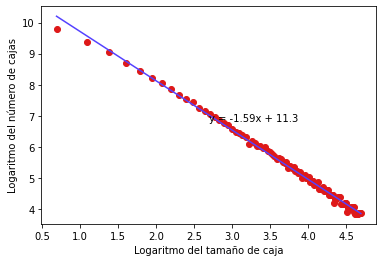

In [19]:
fractalDimRegression = fractalDimensionCalculator.getFractalDimension(110, True)

In [ ]:
print("La dimensión fractal por regresión es "+str(fractalDimRegression))

La dimensión fractal por regresión es 1.5857565001675749


18381.146940383864

# Mandelbrot

In [5]:
#Hacemos una funcion que nos devuelva 0 si el punto 
#converge y si no en cuantas iteraciones se supo que no convergia.#
def getConvergence(x,y):
    nIterations = 50
    z = complex(0,0)
    cValue = complex(x,y)
    iterations = 0
    znext = 0
    cap = 2
    for i in range(0,nIterations):
        iterations += 1
        znext = z**2 + cValue
        if(np.abs(znext)>cap):
            break
        z = znext
    return iterations
    

    

    
    
def createMandelbrotMesh(intervalX, intervalY):
    mesh = np.zeros((len(intervalX),len(intervalY)))
    
    for i in range(0,len(intervalX)):
        for j in range(0,len(intervalY)):
            mesh[j,i] = getConvergence(intervalX[i],intervalY[j])/50
    return mesh



def plotMandelbrot(intervalX,intervalY):
    mesh = createMandelbrotMesh(intervalX,intervalY)
    
    plt.figure(figsize=(10,10))
    
    plt.title("Conjunto de Madelbrot")
    
     
    plt.imshow(mesh)

    return mesh

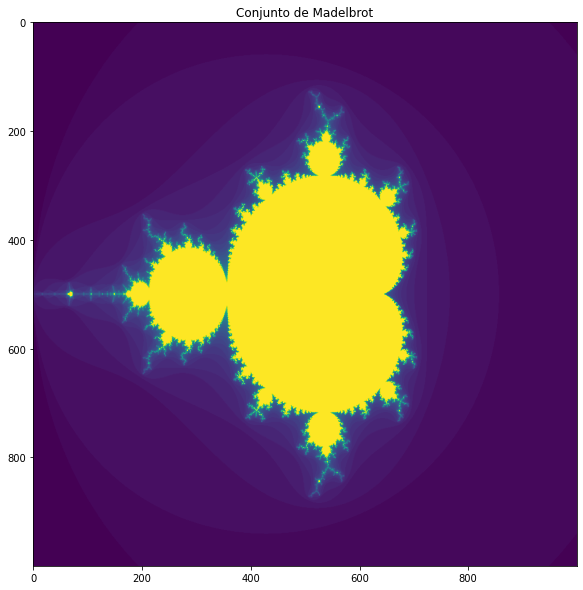

In [8]:
intervalX = np.linspace(-2,1.5,1000)
intervalY = np.linspace(-1.5,1.5,1000)

mandelbrotFig = plotMandelbrot(intervalX,intervalY)

In [9]:
mandelbrotFig

array([[0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       ...,
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
       [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02]])

In [23]:
fractalDimensionCalculatorMand = FractalDimensionCalculator(mandelbrotFig)

In [24]:
N, fractalDimensionMad = fractalDimensionCalculatorMand.computeBoxFractalDimension(2)
print("La dimensión es "+str(fractalDimensionMad))

La dimensión es 2.0
